In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import time  # Add time module for measuring execution tim

In [2]:
class GaussianMixtureModel:
    def __init__(self, n_components=3, max_iterations=10000, 
                 tolerance=1e-4, n_init=10):
        """
        Gaussian Mixture Model with EM Algorithm
        
        Parameters:
        - n_components: Number of mixture components
        - max_iterations: Maximum EM iterations
        - tolerance: Convergence threshold
        - n_init: Number of random initializations
        """
        self.n_components = n_components
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.n_init = n_init
        
        # Model parameters
        self.weights = None
        self.means = None
        self.covariances = None
        
        # Best model tracking
        self.best_weights = None
        self.best_means = None
        self.best_covariances = None
        self.best_log_likelihood = -np.inf
        
        self.log_likelihoods = []
        self.parameter_history = {
            'means': [],
            'weights': [],
            'covariances': []
        }
        
        # Time tracking
        self.timing = {
            'initialization': [],
            'e_step': [],
            'm_step': [],
            'total_fit': 0,
            'per_iteration': []
        }
        

    def random_initialization(self, X):
        """
        Randomly initialize model parameters
        """
        start_time = time.time()
        
        n_samples, n_features = X.shape
        
        # Randomly select initial means
        random_indices = np.random.choice(
            n_samples, 
            size=self.n_components, 
            replace=False
        )
        self.means = X[random_indices]
        
        # Initialize covariances
        data_cov = np.cov(X.T)
        self.covariances = [
            data_cov + np.eye(n_features) * np.random.uniform(0.1, 1.0) 
            for _ in range(self.n_components)
        ]
        
        # Uniform mixture weights
        self.weights = np.ones(self.n_components) / self.n_components
        
        # Record initialization time
        self.timing['initialization'].append(time.time() - start_time)
        
        return self.means, self.covariances, self.weights

    def e_step(self, X):
        """
        Expectation Step: Compute responsibilities
        """
        start_time = time.time()
        
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Compute responsibilities for each component
        for k in range(self.n_components):
            # Multivariate normal distribution
            mvn = multivariate_normal(
                mean=self.means[k], 
                cov=self.covariances[k]
            )
            
            # Compute weighted probability
            responsibilities[:, k] = self.weights[k] * mvn.pdf(X)
        
        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1)[:, np.newaxis]
        responsibilities /= row_sums
        
        # Compute log-likelihood
        log_likelihood = np.sum(np.log(row_sums))
        
        # Record E-step time
        self.timing['e_step'].append(time.time() - start_time)
        
        return responsibilities, log_likelihood

    def m_step(self, X, responsibilities):
        """
        Maximization Step: Update model parameters
        """
        start_time = time.time()
        
        n_samples, n_features = X.shape
        
        # Compute soft cluster counts
        N_k = responsibilities.sum(axis=0)
        
        # Update weights
        self.weights = N_k / n_samples
        
        # Update means
        self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        
        # Update covariances
        self.covariances = []
        for k in range(self.n_components):
            diff = X - self.means[k]
            cov = np.dot(
                (responsibilities[:, k][:, np.newaxis] * diff).T, 
                diff
            ) / N_k[k]
            
            # Add small regularization
            cov += np.eye(n_features) * 1e-6
            self.covariances.append(cov)
        
        # Record M-step time
        self.timing['m_step'].append(time.time() - start_time)
        
        return self.weights, self.means, self.covariances

    def fit(self, X):
        """
        Fit Gaussian Mixture Model using EM Algorithm
        """
        total_start_time = time.time()
        
        for init in range(self.n_init):
            # Random initialization
            self.random_initialization(X)
            
            current_log_likelihood = -np.inf
            
            # EM iterations
            for iteration in range(self.max_iterations):
                iter_start_time = time.time()
                
                # E-step
                responsibilities, log_likelihood = self.e_step(X)
                
                # Check convergence
                if abs(log_likelihood - current_log_likelihood) < self.tolerance:
                    # Record per-iteration time for the final iteration
                    self.timing['per_iteration'].append(time.time() - iter_start_time)
                    break
                
                current_log_likelihood = log_likelihood
                
                # M-step
                self.m_step(X, responsibilities)
                
                # Record per-iteration time
                self.timing['per_iteration'].append(time.time() - iter_start_time)
                
                # Update best model if needed
                if log_likelihood > self.best_log_likelihood:
                    self.best_weights = self.weights.copy()
                    self.best_means = self.means.copy()
                    self.best_covariances = self.covariances.copy()
                    self.best_log_likelihood = log_likelihood
        
        # Set best parameters
        self.weights = self.best_weights
        self.means = self.best_means
        self.covariances = self.best_covariances
        
        # Record total fitting time
        self.timing['total_fit'] = time.time() - total_start_time
        
        return self.means, self.covariances, self.weights
    
    def fit_with_convergence_tracking(self, X):
        """
        Enhanced fit method to track convergence details
        """
        # Reset tracking lists
        self.log_likelihoods = []
        self.parameter_history = {
            'means': [],
            'weights': [],
            'covariances': []
        }
        
        # Reset timing measurements
        self.timing = {
            'initialization': [],
            'e_step': [],
            'm_step': [],
            'total_fit': 0,
            'per_iteration': []
        }
        
        total_start_time = time.time()
        
        for init in range(self.n_init):
            # Random initialization
            self.random_initialization(X)
            
            current_log_likelihood = -np.inf
            
            # EM iterations
            for iteration in range(self.max_iterations):
                iter_start_time = time.time()
                
                # E-step
                responsibilities, log_likelihood = self.e_step(X)
                
                # Track log-likelihood
                self.log_likelihoods.append(log_likelihood)
                
                # Track parameter evolution
                self.parameter_history['means'].append(self.means.copy())
                self.parameter_history['weights'].append(self.weights.copy())
                self.parameter_history['covariances'].append(
                    [cov.copy() for cov in self.covariances]
                )
                
                # Check convergence
                if abs(log_likelihood - current_log_likelihood) < self.tolerance:
                    # Record time for final iteration
                    self.timing['per_iteration'].append(time.time() - iter_start_time)
                    break
                
                current_log_likelihood = log_likelihood
                
                # M-step
                self.m_step(X, responsibilities)
                
                # Record per-iteration time
                self.timing['per_iteration'].append(time.time() - iter_start_time)
        
        # Record total fit time
        self.timing['total_fit'] = time.time() - total_start_time
        
        return self

    def predict(self, X):
        """
        Predict cluster assignments
        """
        start_time = time.time()
        responsibilities, _ = self.e_step(X)
        prediction_time = time.time() - start_time
        
        # Store prediction time
        if 'prediction' not in self.timing:
            self.timing['prediction'] = []
        self.timing['prediction'].append(prediction_time)
        
        return np.argmax(responsibilities, axis=1)
        
    def print_timing_stats(self):
        """
        Print timing statistics for the GMM fitting process
        """
        print("=== GMM Timing Statistics ===")
        print(f"Total fit time: {self.timing['total_fit']:.4f} seconds")
        
        if self.timing['initialization']:
            avg_init = np.mean(self.timing['initialization'])
            print(f"Average initialization time: {avg_init:.4f} seconds")
        
        if self.timing['e_step']:
            avg_e = np.mean(self.timing['e_step'])
            print(f"Average E-step time: {avg_e:.4f} seconds")
        
        if self.timing['m_step']:
            avg_m = np.mean(self.timing['m_step'])
            print(f"Average M-step time: {avg_m:.4f} seconds")
        
        if self.timing['per_iteration']:
            avg_iter = np.mean(self.timing['per_iteration'])
            print(f"Average iteration time: {avg_iter:.4f} seconds")
            print(f"Total iterations: {len(self.timing['per_iteration'])}")
        
        if 'prediction' in self.timing and self.timing['prediction']:
            avg_pred = np.mean(self.timing['prediction'])
            print(f"Average prediction time: {avg_pred:.4f} seconds")

In [3]:
import pandas as pd
import numpy as np

def generate_synthetic_gmm_data(n_samples=3000, n_components=3):
    """
    Generate synthetic data for Gaussian Mixture Model
    
    Parameters:
    - n_samples: Total number of data points
    - n_components: Number of Gaussian distributions to mix
    
    Returns:
    - X: Generated data points
    - true_labels: True cluster assignments
    """
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define means for each Gaussian component
    means = [
        [0, 0],    # Cluster 1
        [3, 3],    # Cluster 2
        [-3, 3]    # Cluster 3
    ]
    
    # Define covariance matrices for each component
    covs = [
        [[1, 0.5], [0.5, 1]],     # Covariance for Cluster 1
        [[1.5, 0], [0, 1.5]],     # Covariance for Cluster 2
        [[1, -0.5], [-0.5, 1]]    # Covariance for Cluster 3
    ]
    
    # Define mixture weights (probabilities of each component)
    weights = [0.3, 0.4, 0.3]
    
    # Prepare output arrays
    X = np.zeros((n_samples, 2))
    true_labels = np.zeros(n_samples, dtype=int)
    
    # Generate samples for each component
    for i in range(n_components):
        # Calculate number of samples for this component
        n = int(n_samples * weights[i])
        
        # Generate samples from this Gaussian
        component_samples = np.random.multivariate_normal(
            mean=means[i], 
            cov=covs[i], 
            size=n
        )
        
        # Assign to appropriate section of X
        start = sum(int(n_samples * weights[j]) for j in range(i))
        end = start + n
        X[start:end] = component_samples
        true_labels[start:end] = i
    
    return X, true_labels

In [4]:
def save_dataset_csv(X, true_labels, prefix="gmm"):
    """
    Save generated dataset to CSV files that are easily readable in C++
    """
    import os
    import pandas as pd
    
    # Create a directory to store datasets if it doesn't exist
    os.makedirs('datasets', exist_ok=True)
    
    # Save data points to CSV
    pd.DataFrame(X, columns=['x', 'y']).to_csv(f'datasets/{prefix}_data.csv', index=False)
    
    # Save labels to CSV
    pd.DataFrame({'label': true_labels}).to_csv(f'datasets/{prefix}_labels.csv', index=False)
    
    print(f"Dataset saved successfully to datasets/{prefix}_data.csv and datasets/{prefix}_labels.csv!")



Dataset saved successfully to datasets/gmm_data.csv and datasets/gmm_labels.csv!
Starting GMM fitting...
GMM fitting completed in 6.9637 seconds
=== GMM Timing Statistics ===
Total fit time: 6.9629 seconds
Average initialization time: 0.0384 seconds
Average E-step time: 0.0805 seconds
Average M-step time: 0.0395 seconds
Average iteration time: 0.1194 seconds
Total iterations: 58

Predicting cluster assignments...
Prediction completed in 0.0823 seconds
Prediction results saved to gmm_results_python.csv
Model parameters saved to gmm_parameters_python.csv


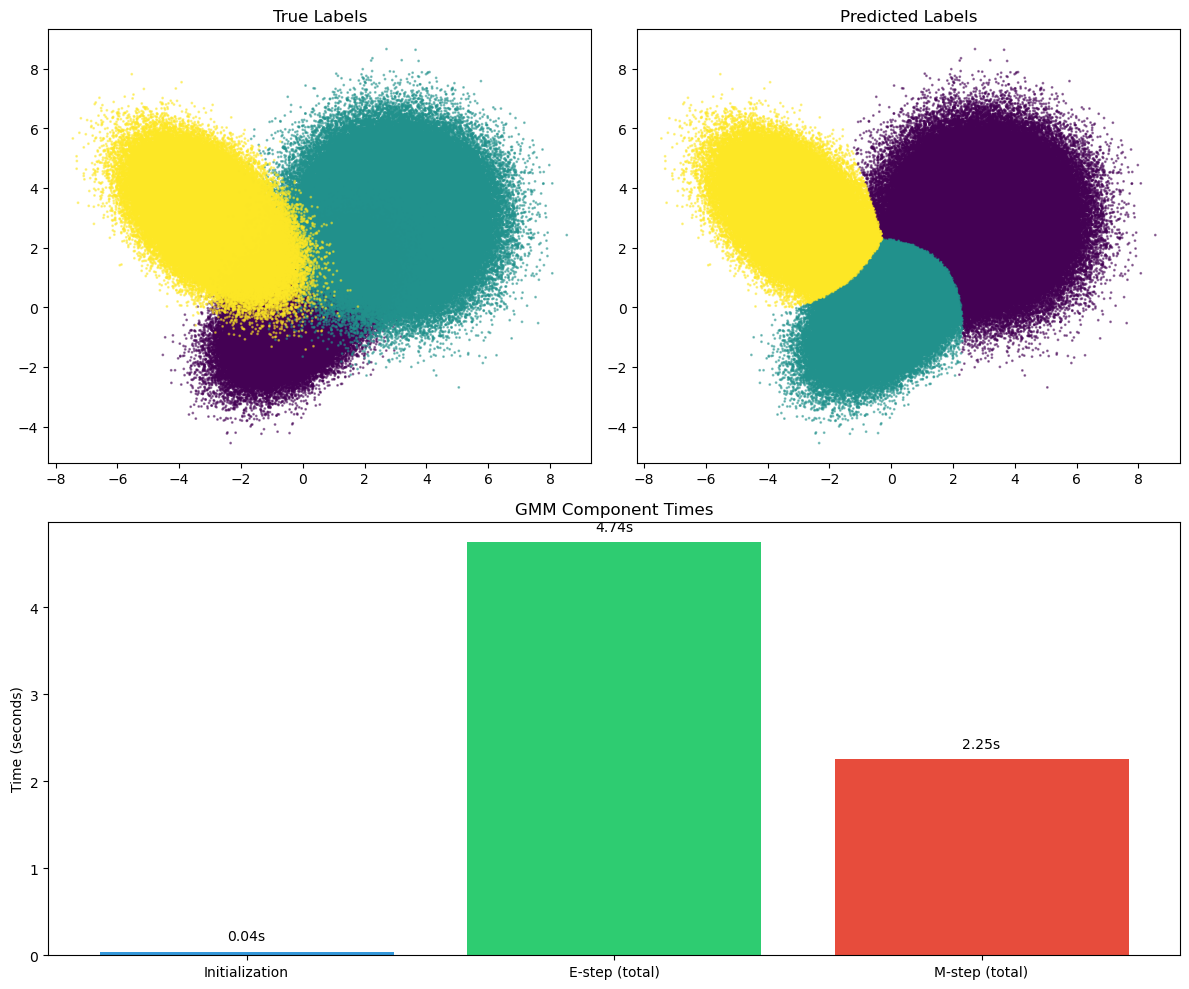


=== GMM Results ===
Means:
  Cluster 0: [2.9976, 3.0008]
  Cluster 1: [0.0029, 0.0001]
  Cluster 2: [-2.9999, 3.0013]

Weights:
  Cluster 0: 0.3997
  Cluster 1: 0.3004
  Cluster 2: 0.3000

Log-Likelihood: -3910910.8306

=== Timing Summary ===
Total runtime: 6.9637 seconds
Average iteration time: 0.1194 seconds
Total iterations: 58
E-step percentage: 68.12%
M-step percentage: 32.35%

Timing information saved to:
  - timing_results/python_gmm_timing_summary.txt


In [5]:
# Fit GMM
X, true_labels = generate_synthetic_gmm_data(n_samples=1000000)
save_dataset_csv(X, true_labels)

print("Starting GMM fitting...")
gmm = GaussianMixtureModel(n_components=3, n_init=1)
total_start = time.time()
means, covs, weights = gmm.fit(X)
total_runtime = time.time() - total_start
print(f"GMM fitting completed in {total_runtime:.4f} seconds")

# Print timing statistics
gmm.print_timing_stats()

# Predict clusters
print("\nPredicting cluster assignments...")
predict_start = time.time()
predicted_labels = gmm.predict(X)
predict_time = time.time() - predict_start
print(f"Prediction completed in {predict_time:.4f} seconds")

# Save results to CSV
results_df = pd.DataFrame({
    'index': np.arange(len(predicted_labels)),
    'predicted_cluster': predicted_labels
})
results_df.to_csv('gmm_results_python.csv', index=False)
print("Prediction results saved to gmm_results_python.csv")

# Save GMM parameters to CSV
params_df = pd.DataFrame({
    'Component': np.arange(gmm.n_components),
    'Weight': gmm.weights,
    'Mean': [f"{mean[0]} {mean[1]}" for mean in gmm.means],
    'Covariance': [f"{cov[0][0]} {cov[0][1]} {cov[1][0]} {cov[1][1]}" for cov in gmm.covariances]
})
params_df.to_csv('gmm_parameters_python.csv', index=False)
print("Model parameters saved to gmm_parameters_python.csv")

# Visualization
plt.figure(figsize=(12, 10))

# Plot clusters
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap='viridis', alpha=0.5, s=1)
plt.title('True Labels')

plt.subplot(222)
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='viridis', alpha=0.5, s=1)
plt.title('Predicted Labels')

# Plot timing information
plt.subplot(212)
timing_labels = ['Initialization', 'E-step (total)', 'M-step (total)']
timing_values = [
    np.sum(gmm.timing['initialization']),
    np.sum(gmm.timing['e_step']),
    np.sum(gmm.timing['m_step'])
]

colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = plt.bar(timing_labels, timing_values, color=colors)
plt.ylabel('Time (seconds)')
plt.title('GMM Component Times')

# Add time values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('gmm_timing_visualization.png')
plt.show()

# Print detailed results
print("\n=== GMM Results ===")
print("Means:")
for i, mean in enumerate(means):
    print(f"  Cluster {i}: [{mean[0]:.4f}, {mean[1]:.4f}]")

print("\nWeights:")
for i, weight in enumerate(weights):
    print(f"  Cluster {i}: {weight:.4f}")

print(f"\nLog-Likelihood: {gmm.best_log_likelihood:.4f}")

# Timing summary
print("\n=== Timing Summary ===")
print(f"Total runtime: {total_runtime:.4f} seconds")
avg_iter = np.mean(gmm.timing['per_iteration'])
print(f"Average iteration time: {avg_iter:.4f} seconds")
print(f"Total iterations: {len(gmm.timing['per_iteration'])}")
e_step_pct = np.sum(gmm.timing['e_step']) / total_runtime * 100
m_step_pct = np.sum(gmm.timing['m_step']) / total_runtime * 100
print(f"E-step percentage: {e_step_pct:.2f}%")
print(f"M-step percentage: {m_step_pct:.2f}%")

# Save timing summary to text file
import os

# Create timing directory if it doesn't exist
os.makedirs('timing_results', exist_ok=True)

# Save a plain text summary for quick reference
with open('timing_results/python_gmm_timing_summary.txt', 'w') as f:
    f.write("=== Python GMM Timing Summary ===\n")
    # f.write(f"Date: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset size: {X.shape[0]} points, {X.shape[1]} dimensions\n")
    f.write(f"Components: {gmm.n_components}\n\n")
    
    f.write("--- Overall Performance ---\n")
    f.write(f"Total runtime: {total_runtime:.4f} seconds\n")
    f.write(f"Total iterations: {len(gmm.timing['per_iteration'])}\n")
    f.write(f"Average iteration time: {avg_iter:.4f} seconds\n")
    f.write(f"Prediction time: {predict_time:.4f} seconds\n\n")
    
    f.write("--- Component Breakdown ---\n")
    f.write(f"Initialization: {np.sum(gmm.timing['initialization']):.4f} seconds\n")
    f.write(f"E-step total: {np.sum(gmm.timing['e_step']):.4f} seconds ({e_step_pct:.2f}%)\n")
    f.write(f"M-step total: {np.sum(gmm.timing['m_step']):.4f} seconds ({m_step_pct:.2f}%)\n\n")
    
    f.write("--- Per Iteration Statistics ---\n")
    f.write(f"Average E-step time: {np.mean(gmm.timing['e_step']):.4f} seconds\n")
    f.write(f"Average M-step time: {np.mean(gmm.timing['m_step']):.4f} seconds\n")

print("\nTiming information saved to:")
print("  - timing_results/python_gmm_timing_summary.txt")